## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. <br>

The first step, I will use machine learning algorithm to predict whether a pair of questions are duplicates or not.<br>
The second step, I will achieve this function, when user input question, if same question or similar question can be found, the previous question will be returned to the user. <br>


I will solve this problem by the following steps:<br>
-1, Get Dataset<br>
-2, Data Exploration<br>
-3, Data Cleaning<br>
-4, Feature Engineering<br>
-5, Modeling<br>
-6, find the same question<br>
-7, Use the Model to find similar question for user<br>


## 1, Get Dataset

In [1]:
import pandas as pd
df = pd.read_csv("train.csv", encoding='cp1252')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## 2, Data Exploration

I try to get a general idea about the data.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50863 entries, 0 to 50862
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50863 non-null  int64 
 1   qid1          50863 non-null  int64 
 2   qid2          50863 non-null  int64 
 3   question1     50863 non-null  object
 4   question2     50863 non-null  object
 5   is_duplicate  50863 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.3+ MB


### I check if there is any missing data.

In [3]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


Based on the above result, there is no missing data in the dataset.

### I check if it is a balanced dataset.

~> Question pairs are not Similar (is_duplicate = 0):
   62.73%

~> Question pairs are Similar (is_duplicate = 1):
   37.27%


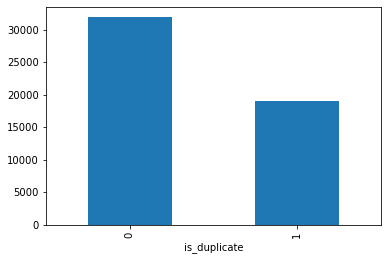

In [4]:
df.groupby("is_duplicate")['id'].count().plot.bar()
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))


Based on the above result, we know it is an imbalanced classification. The imbalanced classification dataset's accuracy is misleading. The overall accuracy would be high simply because one classification has a higher percentage. I will change it to a balanced classification.

### Resampling the dataset
Because we have over 10,000 data in the small classification, I will use under-sampling(removing samples from the majority class) to resample the dataset. This method does not increase new data to the dataset, keeps the original information.


class 0: (31904, 6)
class 1: (18959, 6)
total class of 1 and 0: 0    18959
1    18959
Name: is_duplicate, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

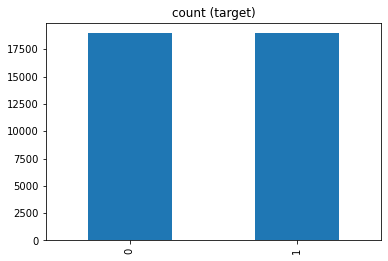

In [18]:
# class count
class_count_0, class_count_1 = df['is_duplicate'].value_counts()

# Separate class
class_0 = df[df['is_duplicate'] == 0]
class_1 = df[df['is_duplicate'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and 0:",test_under['is_duplicate'].value_counts())# plot the count after under-sampeling
test_under['is_duplicate'].value_counts().plot(kind='bar', title='count (target)')

In [19]:
df_b=test_under
df_b.head()

,id,qid1,qid2,question1,question2,is_duplicate
48131,48131,85869,85870,Why was Jaqen H'ghar captured in the first pla...,Why was Jaqen H'ghar being sent to Castle Black?,0
47576,47576,84938,45001,Discuss two model of scientific explanation?,What are the signs of brain tumors or brain ca...,0
8911,8911,17345,17346,"If there has been a real UFO, what is inside i...",Has there been an increase in UFO activity in ...,0
39037,39037,70825,21362,Can someone see the number of times I viewed t...,"If I deleted someone on snapchat, and then mad...",0
21748,21748,40915,40916,Why do most airguns fires pellets intead of re...,Could you fire a bullet into orbit?,0


## 3, Data Cleaning
###  I will deal with the natural language in the following steps
- Change to lower case
- Removing punctuation
- Tokenization
- Stopwords cleaning
- Stemming
- Rejoining

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

#Change to lower case
df_b_l=df_b
df_b_l['question1']=df_b['question1'].astype(str).str.lower()
df_b_l['question2']=df_b['question2'].astype(str).str.lower()

# Removing punctuation
df_b_l["question2"] = df_b_l['question2'].str.replace('[^\w\s]','')
df_b_l["question1"] = df_b_l['question1'].str.replace('[^\w\s]','')

# Tokenization
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 
df_b_l['question1'] = df_b_l.apply(lambda x: tokenize(x['question1']), axis=1)
df_b_l['question2'] = df_b_l.apply(lambda x: tokenize(x['question2']), axis=1)

# Stopwords cleaning
def remove_stopwords(text):
     words=[w for w in text if w not in stopwords.words('english')]
     return words
df_b_l['question1']=df_b_l['question1'].apply(lambda x: remove_stopwords(x))
df_b_l['question2']=df_b_l['question2'].apply(lambda x: remove_stopwords(x))

# Stemming
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer() 
    return [stemmer.stem(word) for word in tokenized_column]
df_b_l['question1'] = df_b_l['question1'].apply(lambda x: apply_stemming(x))
df_b_l['question2'] = df_b_l['question2'].apply(lambda x: apply_stemming(x))

# Rejoining
def rejoin_words(tokenized_column):
    
    return ( " ".join(tokenized_column))

df_b_l['question1'] = df_b_l['question1'].apply(lambda x: rejoin_words(x))
df_b_l['question2'] = df_b_l['question2'].apply(lambda x: rejoin_words(x))

df_b_l.to_csv('dataclean.csv',index=False)
df_b_l.head()

<ipython-input-30-8d1bff48657c>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_b_l["question2"] = df_b_l['question2'].str.replace('[^\w\s]','')
<ipython-input-30-8d1bff48657c>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_b_l["question1"] = df_b_l['question1'].str.replace('[^\w\s]','')


,id,qid1,qid2,question1,question2,is_duplicate
48131,48131,85869,85870,jaqen hghar captur first place two prison skill,jaqen hghar sent castl black,0
47576,47576,84938,45001,discuss two model scientif explan,sign brain tumor brain cancer,0
8911,8911,17345,17346,real ufo insid control go,increa ufo activ recent year could signif,0
39037,39037,70825,21362,someon see number time view snapchat stori,delet someon snapchat made stori public abl see,0
21748,21748,40915,40916,airgun fire pellet intead real bullet bullet s...,could fire bullet orbit,0


## 4, Feature Engineering
I will use the following features<br>
q1len = Length of q1<br>
q2len = Length of q2<br>
q1_n_words = Number of words in Question 1<br>
q2_n_words = Number of words in Question 2<br>
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)<br>
word_Common = (Number of common unique words in Question 1 and Question 2)<br>
word_Unique =(Total num of unique words in Question 1 and Question 2)<br>
jaccard index = (word_common)/(word_Unique)<br>

In [36]:
df_b_l_f = pd.read_csv("dataclean.csv")

#  I calculate q1len and q2len
df_b_l_f['q1len'] = df_b_l_f['question1'].str.len() 
df_b_l_f['q2len'] = df_b_l_f['question2'].str.len()

#  I calculate q1_n_words and q2_n_words
df_b_l_f['q1_n_words'] = df_b_l_f['question1'].apply(lambda row: len(str(row).split(" ")))
df_b_l_f['q2_n_words'] = df_b_l_f['question2'].apply(lambda row: len(str(row).split(" ")))

#  I calculate word_total 
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df_b_l_f['word_Total'] = df_b_l_f.apply(normalized_word_Total, axis=1)


#  I calculate word_Common
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)
df_b_l_f['word_Common'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate word_unique
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(set(w1 | w2))
df_b_l_f['word_unique'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate jaccard index
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)/len(set(w1 | w2))
df_b_l_f['jaccard_index'] = df_b_l_f.apply(normalized_word_share, axis=1)

df_b_l_f.to_csv("clean_feature.csv", index=False)
df_b_l_f.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Total,word_Common,word_unique,jaccard_index
0,48131,85869,85870,jaqen hghar captur first place two prison skill,jaqen hghar sent castl black,0,47.0,28.0,8,5,13.0,2.0,11.0,0.181818
1,47576,84938,45001,discuss two model scientif explan,sign brain tumor brain cancer,0,33.0,29.0,5,5,9.0,0.0,9.0,0.000000
2,8911,17345,17346,real ufo insid control go,increa ufo activ recent year could signif,0,25.0,41.0,5,7,12.0,1.0,11.0,0.090909
3,39037,70825,21362,someon see number time view snapchat stori,delet someon snapchat made stori public abl see,0,42.0,47.0,7,8,15.0,4.0,11.0,0.363636
4,21748,40915,40916,airgun fire pellet intead real bullet bullet s...,could fire bullet orbit,0,60.0,23.0,9,4,12.0,2.0,10.0,0.200000


## 5, Modeling
 Random Forest calculate fast, and can calculate feature importance. I choose grid search for random forest.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

df_b_l_f = pd.read_csv("clean_feature.csv")

df_b_l_f=df_b_l_f.dropna()

y=df_b_l_f['is_duplicate']
X=df_b_l_f.drop(['is_duplicate', 'question1','question2','qid1','qid2','id'], axis = 1)

# split the dataset to training dataset and test dataset
x_train,x_cv,y_train,y_cv=train_test_split(X,y,test_size=0.2,random_state=1)

# Train the model
paramgrid = {'max_depth': list(range(1,20,2)),'n_estimators':list(range(1,200,20))}
Ran_Forest_cv = GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)
Ran_Forest_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",Ran_Forest_cv.best_params_)
print("accuracy :",Ran_Forest_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 11, 'n_estimators': 181}
accuracy : 0.7096943202156064


### I will check the overfitting of random forest 

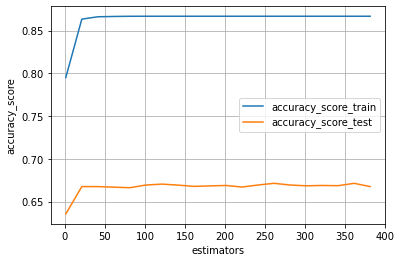

In [42]:
dt_height = []
training_errs = []
testing_errs = []


rf = RandomForestClassifier(n_estimators=1)
df = pd.DataFrame(columns=['n_estimators', 'accuracy_score_train', 'accuracy_score_test'])
for iter in range(20):
    rf.fit(x_train,y_train)
    y_train_predicted = rf.predict(x_train)
    y_test_predicted = rf.predict(x_cv)
    accuracy_score_train =accuracy_score(y_train, y_train_predicted)
    accuracy_score_test = accuracy_score(y_cv, y_test_predicted)
    
    # print("Iteration: {} Train accuracy_score: {} Test accuracy_score: {}".format(iter, accuracy_score_train, accuracy_score_test))
  
    dt_height.append(rf.n_estimators)
    training_errs.append(accuracy_score_train)
    testing_errs.append(accuracy_score_test)
    rf.n_estimators += 20

plt.plot(dt_height, training_errs, label="accuracy_score_train")
plt.plot(dt_height, testing_errs, label="accuracy_score_test")

plt.xlabel("estimators")
plt.ylabel("accuracy_score")
plt.grid(which='major', axis='both')

plt.legend()
plt.show()

When increase tree numbers, the accuracy score has no big change.

### Feature importance based on Decision Tree 

<AxesSubplot:>

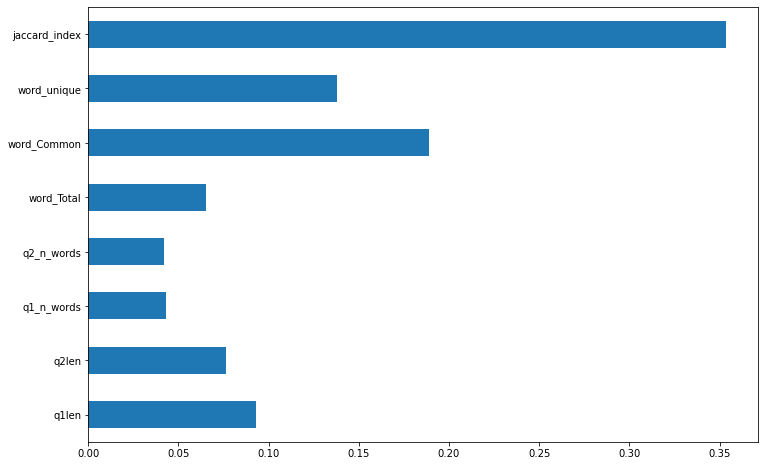

In [43]:
forest_model = RandomForestClassifier(random_state=1,max_depth=11,n_estimators=181)
forest_model.fit(x_train,y_train)
importances = pd.Series(forest_model.feature_importances_,index=X.columns)
importances.plot(kind='barh', figsize=(12,8))

Based on the above chart, we know jaccard index is the most important feature.

### Feature importance based on feature permutation

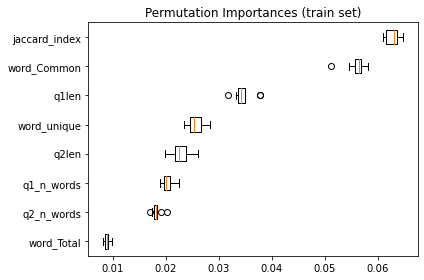

In [29]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=1,max_depth=11,n_estimators=181)
model.fit(x_train,y_train)

result = permutation_importance(
    model, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

Based on the above chart, we know jaccard index is the most important feature. The conclusion is same with decision tree feature importance.

### save the model to file

In [46]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
model=Ran_Forest_cv
pickle.dump(model, open(filename, 'wb'))

In [47]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_cv, y_cv)
print(result)

0.7041045268575954


## 6, find the same question

### Create a unique questions dataframe

In [3]:
import pandas as pd
df = pd.read_csv("train.csv", encoding='cp1252')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
questions = pd.Series(df['question1'].tolist() + df['question2'].tolist())
unique_questions=questions.unique()
df_one = pd.DataFrame(unique_questions, columns = ['question'])
df_one.head()

,question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


### I will define the same question based on a broad criteria. If after changing lower case, removing punctuation, tokenization, removing stop words and stems, two questions are same, I will define they are same questions.

In [5]:
import pandas as pd

#change to lower case
df_one['question_new']=df_one['question'].str.lower()

#Removing punctuation
df_one['question_new'] = df_one['question_new'].str.replace('[^\w\s]','')

# Tokenization
import nltk
df_one=df_one.dropna()

def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 
df_one['question_new'] = df_one.apply(lambda x: tokenize(x['question_new']), axis=1)

# stop words clean
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

def remove_stopwords(text):
     words=[w for w in text if w not in stopwords.words('english')]
     return words
df_one['question_new']=df_one['question_new'].apply(lambda x: remove_stopwords(x))

# Stemming
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer() 
    return [stemmer.stem(word) for word in tokenized_column]
df_one['question_new'] = df_one.apply(lambda x: apply_stemming(x['question_new']), axis=1)

# Rejoining
def rejoin_words(tokenized_column):
    
    return ( " ".join(tokenized_column))
df_one['question_new'] = df_one.apply(lambda x: rejoin_words(x['question_new']), axis=1)

df_one.to_csv('onelistdata.csv',index=False)
df_one.head()

<ipython-input-5-0c4bbff6c48a>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_one['question_new'] = df_one['question_new'].str.replace('[^\w\s]','')


,question,question_new
0,What is the step by step guide to invest in sh...,step step guid invest share market india
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,stori kohinoor kohinoor diamond
2,How can I increase the speed of my internet co...,increas speed internet connect use vpn
3,Why am I mentally very lonely? How can I solve...,mental lone solv
4,"Which one dissolve in water quikly sugar, salt...",one dissolv water quikli sugar salt methan car...


### input a question and search for same question

In [32]:
# get the question dataset
import pandas as pd
df_one2 = pd.read_csv("onelistdata.csv", encoding='cp1252')
df_one2= df_one2.loc[:, ~df_one2.columns.str.contains('^Unnamed')]

# input words
new_question=input('input your question: ')

# change to lowercase
new_question2=new_question.lower()

#Removing punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
no_punct = ""
for char in new_question2:
   if char not in punctuations:
       no_punct = no_punct + char
new_question2 = no_punct

# tokenize
from nltk.tokenize import word_tokenize
new_question2=tokenize(new_question2)

# stop words clean
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

filtered_sentence = []
for word in new_question2: 
    if word not in en_stops:
         filtered_sentence.append(word)
new_question2=filtered_sentence

# import these modules
from nltk.stem import PorterStemmer

  
ps = PorterStemmer()
 
# choose some words to be stemmed
filtered_sentence = []
for w in new_question2:
     filtered_sentence.append(ps.stem(w))
new_question2=filtered_sentence

# Rejoining
new_question2 = ' '.join(map(str, new_question2))

### search the dataset to find if there is same question

df_result=df_one2[df_one2['question_new']==new_question2]['question']
pd.options.display.max_colwidth = 90  # set a value as your need
print("Find the same question", df_result)

input your question: mental lone solv china
Find the same question Series([], Name: question, dtype: object)


## 7,  Use the Model to find similar question for user

In [33]:
df_one2 = pd.read_csv("onelistdata.csv", encoding='cp1252')
df_one2= df_one2.loc[:, ~df_one2.columns.str.contains('^Unnamed')]
df_one2['input_question']=new_question2

df_b_l_f=df_one2
#  I calculate q1len and q2len
df_b_l_f['q1len'] = df_b_l_f['question_new'].str.len() 
df_b_l_f['q2len'] = df_b_l_f['input_question'].str.len()

#  I calculate q1_n_words and q2_n_words
df_b_l_f['q1_n_words'] = df_b_l_f['question_new'].apply(lambda row: len(str(row).split(" ")))
df_b_l_f['q2_n_words'] = df_b_l_f['input_question'].apply(lambda row: len(str(row).split(" ")))

#  I calculate word_total 
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df_b_l_f['word_Total'] = df_b_l_f.apply(normalized_word_Total, axis=1)


#  I calculate word_Common
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * len(w1 & w2)
df_b_l_f['word_Common'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate word_unique
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * len(set(w1 | w2))
df_b_l_f['word_unique'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate jaccard index
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * len(w1 & w2)/len(set(w1 | w2))
df_b_l_f['jaccard_index'] = df_b_l_f.apply(normalized_word_share, axis=1)

#df_b_l_f.head()

df_b_l_f=df_b_l_f.dropna()

X=df_b_l_f.drop(['question','question_new','input_question'], axis = 1)

# load the model from disk
import pickle
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
y_pre=loaded_model.predict(X)
df_pre = pd.DataFrame(y_pre, columns = ['pre'])
result = pd.concat([df_one2, df_pre], axis=1)

df_result=result[result['pre']==1]['question']
pd.options.display.max_colwidth = 90  # set a value as your need
print("Find the similar question: ", df_result.iloc[0])


Find the similar question:  Why am I mentally very lonely? How can I solve it?
